## Logistic Regression

In [119]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
import pandas as pd
import seaborn as sns

In [120]:
df = pd.read_csv('data/dataset.csv')
df = df[df['genre'].notnull()]
df=df.drop(['track','artist','uri'],axis=1)
df.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,genre
1,0.498,0.505,3,-12.475,1,0.0337,0.0180,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,0,60,pop
6,0.662,0.272,0,-18.883,1,0.0313,0.3600,0.228000,0.0963,0.591,143.507,134360,4,47.82155,7,0,60,jazz
9,0.511,0.603,2,-7.637,1,0.0280,0.0385,0.000002,0.1420,0.685,128.336,157293,4,43.36534,9,1,60,pop
11,0.520,0.411,9,-12.411,1,0.0315,0.7860,0.001200,0.1460,0.350,120.290,207573,4,37.54527,9,1,60,pop
13,0.746,0.666,2,-10.408,1,0.1460,0.5430,0.000000,0.0488,0.840,94.024,192427,4,78.59848,5,1,60,country


## Regressions

In [121]:
X=df.drop(['decade','genre','target'],axis=1)
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
1,0.498,0.505,3,-12.475,1,0.0337,0.0180,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10
6,0.662,0.272,0,-18.883,1,0.0313,0.3600,0.228000,0.0963,0.591,143.507,134360,4,47.82155,7
9,0.511,0.603,2,-7.637,1,0.0280,0.0385,0.000002,0.1420,0.685,128.336,157293,4,43.36534,9
11,0.520,0.411,9,-12.411,1,0.0315,0.7860,0.001200,0.1460,0.350,120.290,207573,4,37.54527,9
13,0.746,0.666,2,-10.408,1,0.1460,0.5430,0.000000,0.0488,0.840,94.024,192427,4,78.59848,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41097,0.402,0.696,8,-4.799,0,0.0448,0.0476,0.000000,0.6280,0.227,180.158,243093,3,31.53643,11
41098,0.655,0.632,2,-4.802,1,0.0489,0.0189,0.000000,0.0722,0.447,120.113,188493,4,51.52804,8
41099,0.612,0.807,10,-2.810,1,0.0336,0.0495,0.017700,0.1010,0.398,124.053,240400,4,91.20552,7
41103,0.719,0.804,10,-4.581,1,0.0355,0.0132,0.000003,0.1390,0.605,119.999,227760,4,20.73371,7


In [122]:
genres=df.genre.unique()
y_columns = [f'is_{gen}' for gen in genres]
for gen in genres:
    df[f'is_{gen}']=df['genre']==gen
X_train, X_test, y_train, y_test=train_test_split(X,df[y_columns])

In [123]:
models={}
for gen in genres:
    models[f'is_{gen}']=LogisticRegression(solver='liblinear',random_state=0)

In [124]:
for model in models:
    models[model].fit(X_train,y_train[model])

In [125]:
df_pred=pd.DataFrame()
df_pred_bool=pd.DataFrame()
for model in models:
    df_pred_bool[f'predict_{model}']=models[model].predict(X_test)
    df_pred[f'predict_{model}']=[b for a, b in models[model].predict_proba(X_test)]

In [126]:
df_pred['final_pred']=df_pred.idxmax(axis=1)

In [127]:
df_pred

,predict_is_pop,predict_is_jazz,predict_is_country,predict_is_rock,predict_is_blues,predict_is_funk,predict_is_hip-hop,predict_is_metal,predict_is_techno,final_pred
0,0.322779,0.037931,0.061358,0.242102,0.014141,0.030613,0.054471,0.040057,0.004224,predict_is_pop
1,0.376172,0.034301,0.134453,0.314540,0.034629,0.035954,0.062603,0.046345,0.007122,predict_is_pop
2,0.357649,0.011606,0.103787,0.288682,0.016639,0.013555,0.029151,0.021168,0.001962,predict_is_pop
3,0.353048,0.034693,0.097121,0.282371,0.023878,0.032873,0.054617,0.036849,0.004169,predict_is_pop
4,0.317311,0.058656,0.056248,0.235073,0.015246,0.042823,0.069508,0.049584,0.005922,predict_is_pop
...,...,...,...,...,...,...,...,...,...,...
5072,0.352396,0.078884,0.096217,0.281481,0.032495,0.063844,0.084348,0.053435,0.010135,predict_is_pop
5073,0.362401,0.075505,0.111090,0.295247,0.037973,0.064980,0.091214,0.061397,0.010746,predict_is_pop
5074,0.338075,0.051739,0.077755,0.262173,0.021521,0.042775,0.065789,0.045048,0.005113,predict_is_pop
5075,0.315624,0.041135,0.054734,0.232920,0.013286,0.031893,0.049934,0.034621,0.002451,predict_is_pop


In [128]:
df_pred['final_pred'].value_counts()

predict_is_pop     5034
predict_is_jazz      43
Name: final_pred, dtype: int64

## LDA visualisation


In [129]:
lda=LinearDiscriminantAnalysis(n_components=2)
lda_red=lda.fit(X,df['genre']).transform(X)

<AxesSubplot:>

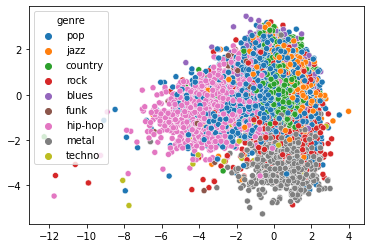

In [130]:
sns.scatterplot(x=lda_red[:,0], y=lda_red[:,1],hue=df['genre'])

In [131]:
X_train, X_test, y_train, y_test=train_test_split(X,df['genre'])

In [132]:
lda_predictions=LinearDiscriminantAnalysis(n_components=2)
lda_predictions.fit(X_train,y_train)

LinearDiscriminantAnalysis(n_components=2)

In [133]:
pred=lda_predictions.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)

In [134]:
print(classification_report(y_test, pred))
print(accuracy_score(y_test,pred))

              precision    recall  f1-score   support

       blues       0.15      0.06      0.08       137
     country       0.50      0.02      0.03       540
        funk       0.29      0.06      0.10       257
     hip-hop       0.64      0.62      0.63       375
        jazz       0.55      0.43      0.48       330
       metal       0.62      0.58      0.60       226
         pop       0.47      0.71      0.57      1826
        rock       0.52      0.49      0.50      1346
      techno       0.23      0.42      0.30        40

    accuracy                           0.50      5077
   macro avg       0.44      0.38      0.37      5077
weighted avg       0.49      0.50      0.45      5077

0.49517431554067365


<AxesSubplot:>

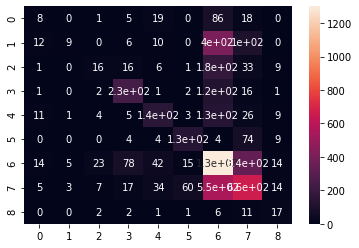

In [135]:
sns.heatmap(conf_matrix,annot=True)

In [136]:
qda_predictions=QuadraticDiscriminantAnalysis()
qda_predictions.fit(X_train,y_train)

QuadraticDiscriminantAnalysis()

In [137]:
pred=qda_predictions.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)

<AxesSubplot:>

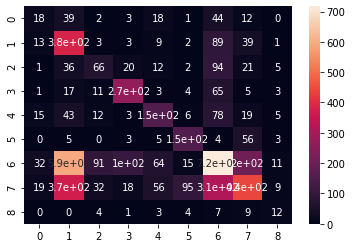

In [138]:
sns.heatmap(conf_matrix,annot=True)

In [139]:
print(classification_report(y_test, pred))
print(accuracy_score(y_test,pred))


              precision    recall  f1-score   support

       blues       0.18      0.13      0.15       137
     country       0.26      0.71      0.38       540
        funk       0.30      0.26      0.28       257
     hip-hop       0.63      0.71      0.67       375
        jazz       0.47      0.45      0.46       330
       metal       0.54      0.66      0.59       226
         pop       0.51      0.39      0.44      1826
        rock       0.55      0.33      0.41      1346
      techno       0.24      0.30      0.27        40

    accuracy                           0.43      5077
   macro avg       0.41      0.44      0.41      5077
weighted avg       0.48      0.43      0.43      5077

0.4333267677762458
